# 알고리즘 체인과 파이프라인

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import koreanize_matplotlib
import matplotlib.pyplot as plt
import mglearn

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge

In [3]:
#데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

#훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

#훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)

svm = SVC()
#스케일 조정된 훈련데이터에 SVM을 학습합니다
svm.fit(X_train_scaled, y_train)
#테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


In [4]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid=GridSearchCV(SVC(), param_grid=param_grid, cv=10)
grid.fit(X_train_scaled, y_train)

print("최상의 교차검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


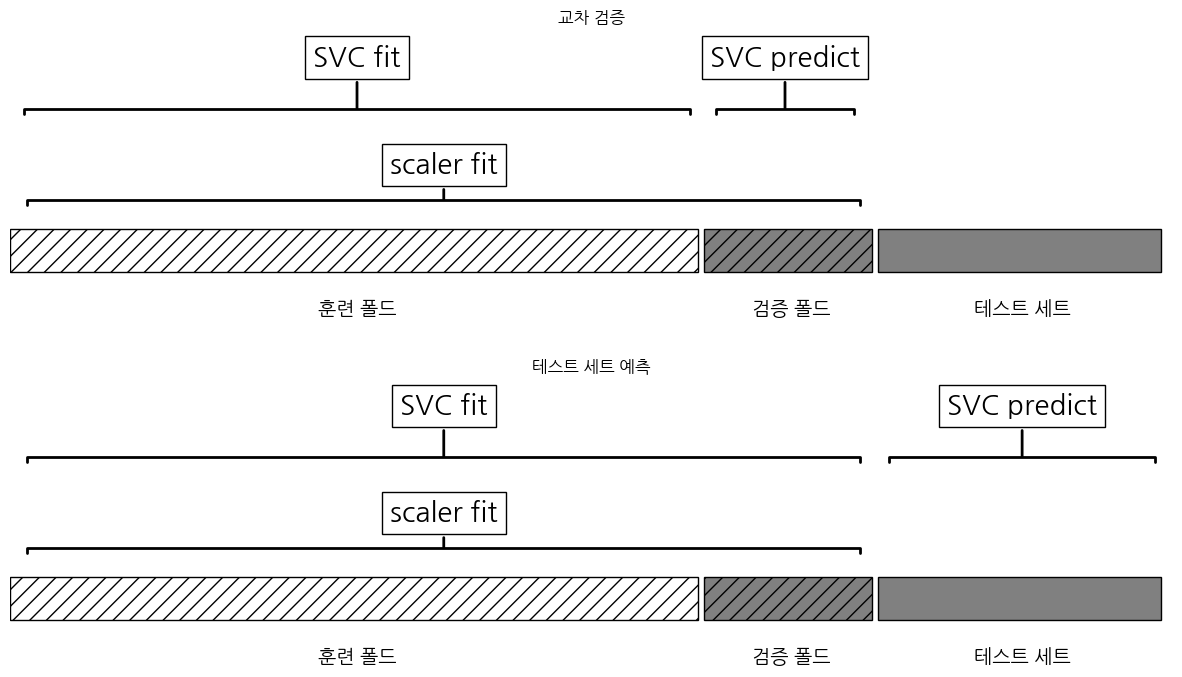

In [5]:
mglearn.plots.plot_improper_processing()

## 파이프라인 구축하기

In [6]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm",SVC())]) #튜플 쓰는 이유: 키밸류 쓰면 안됨(순서 보장 X)

In [7]:
param_grid = {'svm__C':[0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid=GridSearchCV(pipe, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

print("최상의 교차검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차검증 정확도: 0.98
테스트 점수: 0.37
최적의 매개변수:  {'svm__C': 1, 'svm__gamma': 1}


## 모델 선택을 위한 그리드 서치

- 파이썬은 1코어 1쓰레드 (치명적인 단점)
- 주피터노트북이 대부분의 기능을 흡수한 지금, 파이프라인을 사용하는 거의 유일한 이유

In [8]:
# 보스턴 주택 데이터셋이 1.2 버전에서 삭제되므로 직접 다운로드합니다.
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [9]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

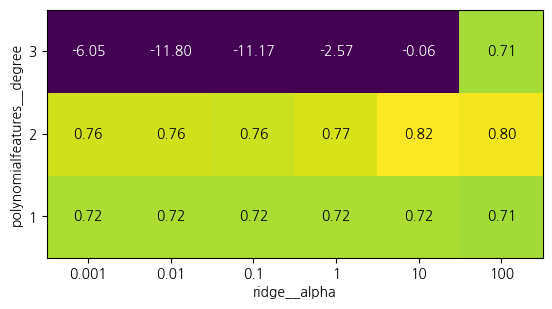

In [11]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)
plt.show() # 책에는 없음

In [12]:
print("최적의 매개변수:", grid.best_params_)
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
테스트 세트 점수: 0.77


In [13]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


## 모델 선택을 위한 그리드 서치


In [14]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [15]:
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


## 중복 계산 피하기

In [17]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")